In [1]:
import sys
sys.path.insert(0, '..')


from src.preprocessing import prepare_corporate_ratings, annualize_and_fill_ratings, create_quarterly_rating_transitions, truncating_data

#importlib.reload(src.preprocessing)

DATA_PATH = "../data/credit_ratings/data_rating_corporate.csv"

df_initial = prepare_corporate_ratings(DATA_PATH)

# 2. Appeler la fonction de traitement ANNUEL
# Le résultat est stocké dans l'objet 'data_rating_yearly'
data_rating_yearly = annualize_and_fill_ratings(df_initial)

# 3. Appeler la fonction de traitement TRIMESTRIEL
# Le résultat est stocké dans l'objet 'data_rating_quarterly'
data_rating_quarterly = create_quarterly_rating_transitions(df_initial)

# 4. La raison pour laquelle il y a 1 an d'écart entre les 2 datasets est que la base de donénes trimestrielle intègre uniquement les transistion qui ont lieu au Y=1 doncpour que les 2 bases 
# soit équivalentes, il faut enlever la dernière année de la base annuelle en terme de période, on met un décalage d'1 an.data_rating_yearly_updated_date = truncating_data(data_rating_yearly, date_begin="2011-01-01", date_finish="2023-12-31")
data_rating_quarterly_updated_date = truncating_data(data_rating_quarterly, date_begin="2011-01-01", date_finish="2022-12-31")
data_rating_yearly_updated_date = truncating_data(data_rating_yearly, date_begin="2011-01-01", date_finish="2023-12-31")


✅ Données chargées et préparées avec succès.


g:\Mon Drive\PROJET_ESA_SRESS_TEST_SQUARE_MANAGEMENT\notebooks\..\src\preprocessing.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_gaps)                         # Appliquer la fonction de réindexation


Les différents secteurs sont représentés ci dessous : 

In [7]:
data_rating_quarterly_updated_date["nace"].unique()

array(['RU', 'JZ', 'OQ', 'MN', 'DZ', 'C5', 'KZ', 'HZ', 'GZ', 'C1', 'FZ',
       'LZ', 'CH', 'C3', 'BZ', 'IZ', 'AZ', 'C2'], dtype=object)

In [9]:
from src.preprocessing import SectorPortfolio

industrie_portfolio = SectorPortfolio.create_from_processed_data(
    name="industrie",
    sectors=['C1', 'C2', 'C3', 'C5'], # 
    annual_data=data_rating_yearly_updated_date,
    quarterly_data=data_rating_quarterly_updated_date
)

# Créer autant de portefeuils sectoriels que vous souhaitez

# Ensuite vous pouvez appeler les différents objets :
print("✅ Portefeuille créé :", industrie_portfolio.name)
print("📊 Secteurs inclus :", industrie_portfolio.sectors)
# print("🔹 Données annuelles :", industrie_portfolio.annual_data)
# print("🔹 Données annuelles :", industrie_portfolio.quarterly_data)


✅ Portefeuille créé : industrie
📊 Secteurs inclus : ['C1', 'C2', 'C3', 'C5']


PD TTC homogène : 0.58 %
Barrière : -2.522082210517084
Rho : 20.96 %


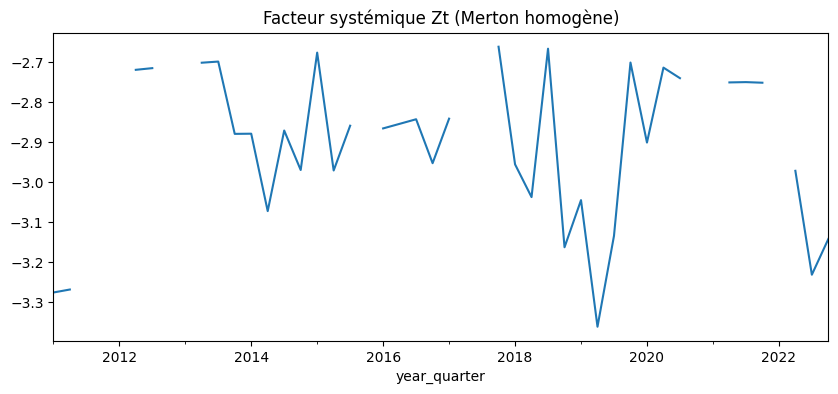

In [19]:
import importlib

import src.merton_homo
importlib.reload(src.merton_homo)
from src.merton_homo import MertonHomogeneous

merton_industry = MertonHomogeneous(industrie_portfolio)
zt_industry = merton_industry.compute()

print("PD TTC homogène :", round(merton_industry.p_ttc*100,2),"%")
print("Barrière :", merton_industry.barriers)
print("Rho :", round(merton_industry.rho*100,2),"%")

zt_industry.plot()

In [ ]:
import src.merton
importlib.reload(src.merton)
from src.merton import Merton


merton_industrie_portfolio = Merton(industrie_portfolio)
zt = merton_industrie_portfolio.compute()

print("PD TTC :\n", round(merton_industrie_portfolio.pd_ttc*100,4))
print("Barrière :\n", merton_industrie_portfolio.barrier)
print("Rho :\n", round(merton_industrie_portfolio.rho*100,2))

zt.plotting_zt()
zt.plot_transitions()


p_ij TTC :
 next_rating    AAA      A    BBB     BB      B      C     D
rating                                                     
AAA          87.96  10.58   0.73   0.61   0.12   0.00  0.00
A             2.57  89.48   7.33   0.44   0.18   0.00  0.00
BBB           0.05   5.94  88.59   4.83   0.46   0.10  0.03
BB            0.00   0.46   6.55  84.02   8.14   0.61  0.21
B             0.13   0.13   0.86   6.68  83.36   7.98  0.86
C             0.00   0.00   0.00   1.42  20.44  70.13  8.02
D             0.00   0.00   0.00   0.00   0.00   0.00  0.00
Barrière :
 next_rating  AAA         A       BBB        BB         B         C         D
rating                                                                      
AAA          inf -1.172800 -2.180815 -2.442188 -3.031541      -inf      -inf
A            inf  1.948098 -1.408657 -2.500332 -2.916040      -inf      -inf
BBB          inf  3.284047  1.555934 -1.605119 -2.519034 -3.016371 -3.474587
BB           inf       inf  2.605175  1.475085 -1.3

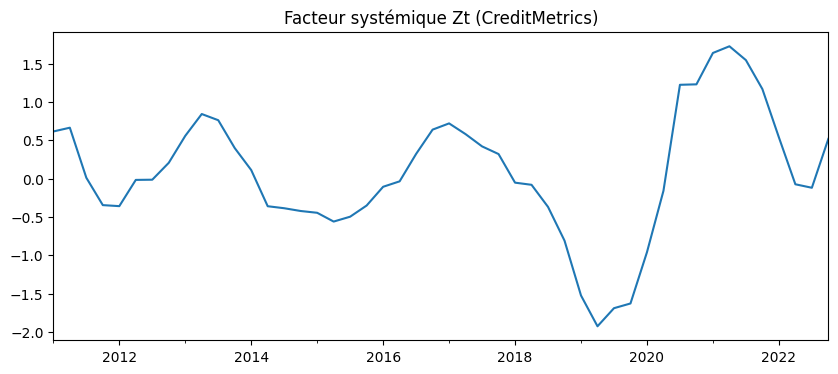

La MSE entre les proba de migration estimés et les proba de migration observés est de  0.001022


In [ ]:
import src.creditmetrics 
importlib.reload(src.creditmetrics)
from src.creditmetrics import CreditMetrics

cm_industrie_portfolio = CreditMetrics(industrie_portfolio)
zt = cm_industrie_portfolio.compute()

print("p_ij TTC :\n", round(cm_industrie_portfolio.migration_ttc*100,2))
print("Barrière :\n", cm_industrie_portfolio.barrier_matrix)
print("Rho :\n", round(cm_industrie_portfolio.rho*100,2))
# Voir les valeurs directement
    
# Plot
zt.plot()

# Calcule la MSE entre les les probabilités estimés avec le modèle de CreditMetrics (avec le  Z estimé) et les probabilités observées
print("La MSE entre les proba de migration estimés et les proba de migration observés est de ",round(zt.mse,6))

# Affiche les probabilités estimés avec le modèle de CreditMetrics (avec le  Z estimé) et les probabilités observées
zt.plot_transitions([["BBB", "B"], ["C", "D"]])

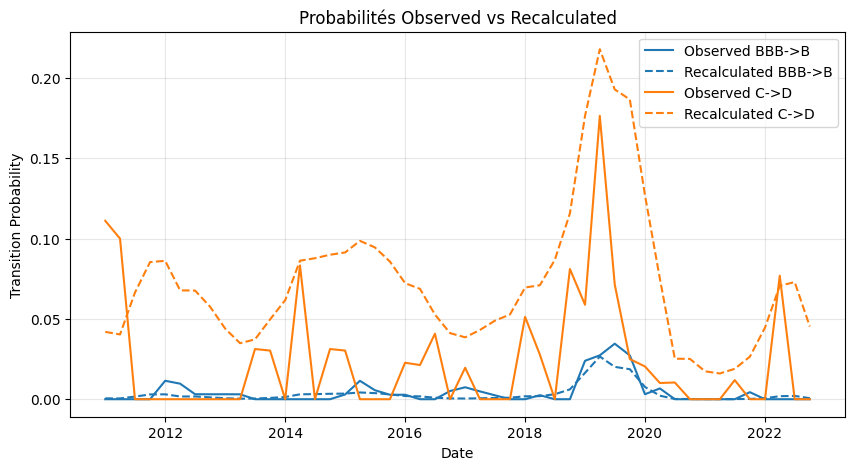

In [42]:
import src.creditmetrics 
importlib.reload(src.creditmetrics)
from src.creditmetrics import CreditMetrics

cm_industrie_portfolio = CreditMetrics(industrie_portfolio)

zt = cm_industrie_portfolio.compute()


zt.plot_transitions([["BBB", "B"], ["C", "D"]])
